In [31]:
import requests  # requests 모듈 임포트
import pandas as pd

def download_file(file_url, save_path):
    with open(save_path, 'wb') as f: # 저장할 파일을 바이너리 쓰기 모드로 열기
        response = requests.get(file_url) # 파일 URL에 GET 요청 보내기
        f.write(response.content) # 응답의 내용을 파일에 쓰기

import pandas as pd

def generate_time_list(start_date, end_date, interval='1H'):
    """
    주어진 시작 날짜와 종료 날짜, 시간 간격에 따라 시점 리스트를 생성하는 함수.
    2023년 1월 1일 이전 시점은 1시간, 2시간, 3시간, 6시간, 12시간, 24시간 간격만 허용됨.
    
    :param start_date: 시작 날짜 (예: '2023-01-01')
    :param end_date: 종료 날짜 (예: '2023-01-02')
    :param interval: 시간 간격 (예: '1H', '2H', '3H', '6H', '12H', '24H', '30T', '15T', '10T', '5T')
    :return: 시점 리스트 (예: ['202301010000', '202301010030', ...])
    """
    try:
        # 입력 날짜를 datetime 형식으로 변환
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        cutoff_date = pd.to_datetime('2023-01-01')

        # 유효성 검사
        if start > end:
            raise ValueError("시작 날짜는 종료 날짜보다 이전이어야 합니다.")
        
        # 지원하는 시간 간격
        allowed_intervals_pre_2023 = ['1H', '2H', '3H', '6H', '12H', '24H']
        allowed_intervals_post_2023 = allowed_intervals_pre_2023 + ['30T', '15T', '10T', '5T']

        # 2023년 1월 1일 이전 시점이 포함되면 제한된 간격만 허용
        if start < cutoff_date:
            if interval not in allowed_intervals_pre_2023:
                raise ValueError(f"2023년 1월 1일 이전 시점은 다음 간격만 허용됩니다: {allowed_intervals_pre_2023}")
        
        # 2023년 1월 1일 이후 시점은 모든 허용된 간격 사용 가능
        elif interval not in allowed_intervals_post_2023:
            raise ValueError(f"지원하지 않는 시간 간격입니다. 허용된 간격: {allowed_intervals_post_2023}")

        # 시간 리스트 생성
        time_range = pd.date_range(start=start, end=end, freq=interval)
        time_list = [time.strftime('%Y%m%d%H%M') for time in time_range]
        
        return time_list

    except Exception as e:
        print(f"오류: {e}")
        return []

In [ ]:
import requests
import xarray as xr
import numpy as np
import netCDF4 as nc

# 파일 다운로드 함수
def download_file(file_url, save_path):
    with open(save_path, 'wb') as f:
        response = requests.get(file_url)
        f.write(response.content)

# 시점과 요소 목록을 지정
times = generate_time_list('2023-01-01', '2023-01-02', '6H')  # 시점 리스트
obs_list = ['ta', 'hm', 'ps']  # 요소 리스트 ta(기온), hm(상대습도), td(이슬점온도), ws_10m(10분 평균풍속), wind(바람(풍향,풍속,U,V), pa(현지기압), ps(해면기압), rn_ox(강수유무), rn_15m(15분강수), rn_60m(60분강수), rn_day(일강수), vs(시정), sd_tot(적설), sd_day(일신적설), sd_3hr(3시간신적설), sd_24h(24시간신적설)

# 시점별로 데이터를 저장할 리스트
data_arrays_per_time = []

for kst in times:
    obs_data_list = []  # 하나의 time에 대해 여러 obs를 저장할 리스트
    for obs in obs_list:
        # 파일 다운로드 경로와 URL 설정
        file_path = f'data/{kst}_{obs}.txt'
        url = f'https://apihub.kma.go.kr/api/typ01/url/sfc_grid_nc_down.php?obs={obs}&tm={kst}&authKey=cxFprjmGTxSRaa45hl8UhQ'
        
        # 파일 다운로드
        download_file(url, file_path)

        ds = xr.open_dataset(file_path, engine='netcdf4')
        data_array = ds.to_array().values  # xarray 객체를 numpy 배열로 변환
        if obs == 'ta': 
            data_array = data_array / 10
        data_array = data_array[::-1, ::-1] 
        data_array = data_array[0]

        # 데이터 배열의 차원을 맞추기
        data_array = data_array[np.newaxis, ...]  # obs 차원 추가

        # 데이터 배열을 xarray.DataArray로 변환
        xr_data = xr.DataArray(
            data_array,
            dims=['obs', 'x', 'y'],
            coords={
                'obs': [obs],
                'x': np.arange(2049),
                'y': np.arange(2049)    
            }
        )
        obs_data_list.append(xr_data)

    # 하나의 time에 대한 모든 obs 데이터 결합
    time_data = xr.concat(obs_data_list, dim='obs')
    time_data = time_data.expand_dims(dim={'time': [np.datetime64(kst[:4] + '-' + kst[4:6] + '-' + kst[6:8] + 'T' + kst[8:10] + ':' + kst[10:12])]})
    data_arrays_per_time.append(time_data)

# 모든 time 데이터를 결합하여 최종 DataArray 생성
combined_data = xr.concat(data_arrays_per_time, dim='time')

print(combined_data)


C:\Users\Kyujin\AppData\Local\Temp\ipykernel_2388\1700783163.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=start, end=end, freq=interval)
C:\Users\Kyujin\AppData\Local\Temp\ipykernel_2388\2067500824.py:53: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_data = time_data.expand_dims(dim={'time': [np.datetime64(kst[:4] + '-' + kst[4:6] + '-' + kst[6:8] + 'T' + kst[8:10] + ':' + kst[10:12])]})
C:\Users\Kyujin\AppData\Local\Temp\ipykernel_2388\2067500824.py:53: UserWarning: Converting non-nan

<xarray.DataArray (time: 5, obs: 4, x: 2049, y: 2049)> Size: 672MB
array([[[[ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.],
         [ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.],
         [ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.],
         ...,
         [ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.],
         [ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.],
         [ -999.,  -999.,  -999., ...,  -999.,  -999.,  -999.]],

        [[-9990., -9990., -9990., ..., -9990., -9990., -9990.],
         [-9990., -9990., -9990., ..., -9990., -9990., -9990.],
         [-9990., -9990., -9990., ..., -9990., -9990., -9990.],
         ...,
         [-9990., -9990., -9990., ..., -9990., -9990., -9990.],
         [-9990., -9990., -9990., ..., -9990., -9990., -9990.],
         [-9990., -9990., -9990., ..., -9990., -9990., -9990.]],

        [[-9990., -9990., -9990., ..., -9990., -9990., -9990.],
         [-9990., -9990., -9990., ..., -9990., -9990., -9990.],
     

C:\Users\Kyujin\AppData\Local\Temp\ipykernel_2388\2067500824.py:53: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  time_data = time_data.expand_dims(dim={'time': [np.datetime64(kst[:4] + '-' + kst[4:6] + '-' + kst[6:8] + 'T' + kst[8:10] + ':' + kst[10:12])]})
C:\Users\Kyujin\AppData\Local\Temp\ipykernel_2388\2067500824.py:57: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused

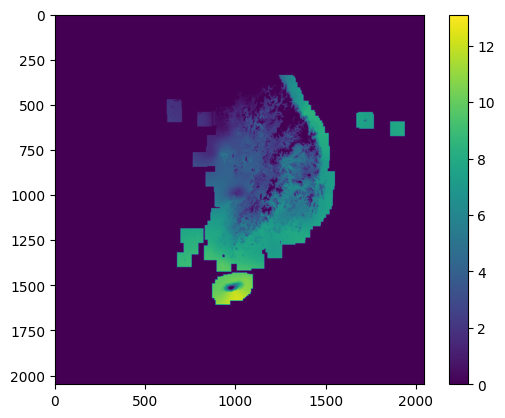

In [40]:
import matplotlib.pyplot as plt

data_at_time = combined_data.sel(time='2023-01-01T12:00',obs ='ta')
data_at_time = data_at_time.to_numpy()
mask = data_at_time > 0
data_at_time = data_at_time * mask
plt.imshow(data_at_time, cmap='viridis')  # viridis는 색상이 진해지는 컬러맵
plt.colorbar()  # 색상 막대 추가 (값에 따른 색상 범위 표시)
plt.show()